# Generative Adversarial Network for ECG synthesis
This notebook is an addition to this [notebook](https://www.kaggle.com/polomarco/ecg-classification-cnn-lstm-attention-mechanism).

C:\Users\jespe\AppData\Local\Temp\ipykernel_34332\574050403.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plt.imshow(io.imread("https://i.pinimg.com/originals/97/c8/0e/97c80e536a8b8712a8299dddb9f14e07.jpg"))


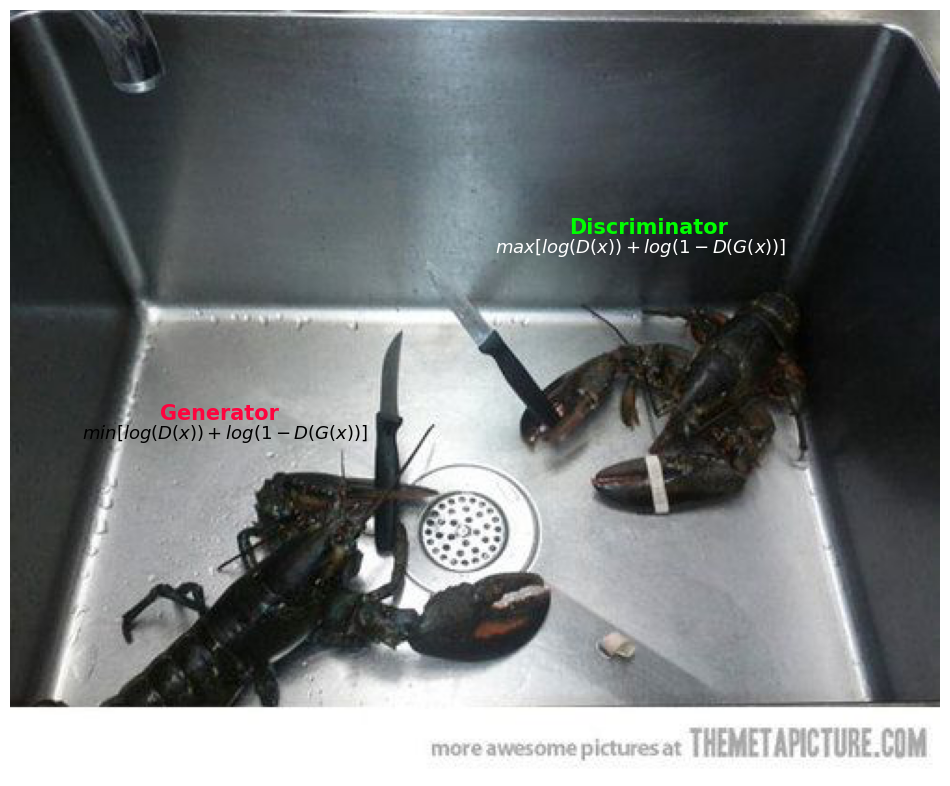

In [1]:
import matplotlib.pyplot as plt
import cv2
import imageio as io

lat_D = 'max[log(D(x))+log(1-D(G(x))]'
lat_G = 'min[log(D(x))+log(1-D(G(x))]'

plt.figure(figsize=(12, 10))
plt.imshow(io.imread("https://i.pinimg.com/originals/97/c8/0e/97c80e536a8b8712a8299dddb9f14e07.jpg"))
plt.axis('off');

plt.text(80, 220, "Generator", 
         fontdict={
             "fontsize":15,
             "color":"#FF033E",
             "weight": "bold"
             }
         );
plt.text(38, 230, r"$%s$" % lat_G, 
         fontdict={
             "fontsize":13,
             "color":"black",
             "weight": "bold"
             }
         );
                                                                                               
plt.text(300, 120, r"Discriminator", 
         fontdict={
             "fontsize":15,
             "color":"lime",
             "weight": "bold"
             }
         );
         
plt.text(260, 130, r"$%s$" % lat_D,
         fontdict=
         {"fontsize":13,
          "color":"white",
          "weight": "bold"
          }
         );

![](https://64.media.tumblr.com/66dc00e688f72af4d7b5d768005359c4/094fefb7e60b17ee-9c/s500x750/3060385c5fdcb38f3a716d8a309a40e69e598a5f.png)

In [2]:
import os
import time

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW, Adam


In [3]:
# Def to combine all CSV files in a directory into a single DataFrame
def combine_csv_files_to_df(dir_path):
    # Get all CSV files in the directory
    csv_files = [file for file in os.listdir(dir_path) if file.endswith('.csv')]

    df_list = [pd.read_csv(os.path.join(dir_path, file), header=None) for file in csv_files]
    combined_data = pd.concat(df_list, ignore_index=True,)

    # Display the combined DataFrame
    return(combined_data)


In [4]:
class Config:
    csv_path = ''
    seed = 2021
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

def seed_everything(seed: int):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
    
config = Config()
seed_everything(config.seed)

In [20]:
# df_ptbdb = pd.read_csv('/kaggle/input/heartbeat/ptbdb_abnormal.csv')
df_mitbih = combine_csv_files_to_df('./Dataset_mitbih/Training/')
df_mitbih.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [56]:
df_mitbih_train = combine_csv_files_to_df('./Dataset_mitbih/Training/')
df_mitbih_test = combine_csv_files_to_df('./Dataset_mitbih/Testing/')
df_mitbih = pd.concat([df_mitbih_train, df_mitbih_test], axis=0)

# Delete half of the rows with the label 1
# count the number of rows with label 1
num_label_1 = (df_mitbih[187] == 1).sum()

# calculate the number of rows to drop
num_to_drop = num_label_1 // 2

# create a boolean mask for the rows to keep
mask = ~((df_mitbih[187] == 1) & (np.arange(len(df_mitbih)) < num_to_drop))

# drop the rows that match the mask
df = df_mitbih.drop(df_mitbih[mask].index)

# Add the new data to the original data
outliers = pd.read_csv('Artial_Premature_Outliers.csv', header=None)
df_mitbih = pd.concat([df_mitbih, outliers], axis=0)

df_mitbih.rename(columns={187: 'class'}, inplace=True)

id_to_label = {
    0: "Normal",
    1: "Artial Premature",
    2: "Premature ventricular contraction",
    3: "Fusion of ventricular and normal",
    4: "Fusion of paced and normal"
}
df_mitbih['label'] = df_mitbih.iloc[:, -1].map(id_to_label)
print(df_mitbih.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110143 entries, 0 to 696
Columns: 189 entries, 0 to label
dtypes: float64(188), object(1)
memory usage: 159.7+ MB
None


In [57]:
df_mitbih

,0,1,2,3,4,5,6,7,8,9,...,179,180,181,182,183,184,185,186,class,label
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,Normal
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,Normal
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,Normal
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,Normal
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
692,1.000000,0.768683,0.185053,0.056940,0.099644,0.124555,0.117438,0.185053,0.217082,0.170819,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.0,Artial Premature
693,1.000000,0.938182,0.372727,0.089091,0.089091,0.056364,0.045455,0.081818,0.145455,0.276364,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.0,Artial Premature
694,0.723301,0.723301,0.281553,0.000000,0.063107,0.111650,0.082524,0.082524,0.184466,0.165049,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.0,Artial Premature
695,0.735751,0.746114,0.243523,0.000000,0.056995,0.093264,0.082902,0.093264,0.181347,0.129534,...,0.367876,0.336788,0.336788,0.362694,0.38342,0.352332,0.326425,0.352332,1.0,Artial Premature


In [58]:
df_mitbih.to_csv('data.csv', index=False)
config.csv_path = 'data.csv'

# Basic EDA

In [60]:
df_mitbih['label'].value_counts()

Normal                               90589
Fusion of paced and normal            8039
Premature ventricular contraction     7236
Artial Premature                      3476
Fusion of ventricular and normal       803
Name: label, dtype: int64

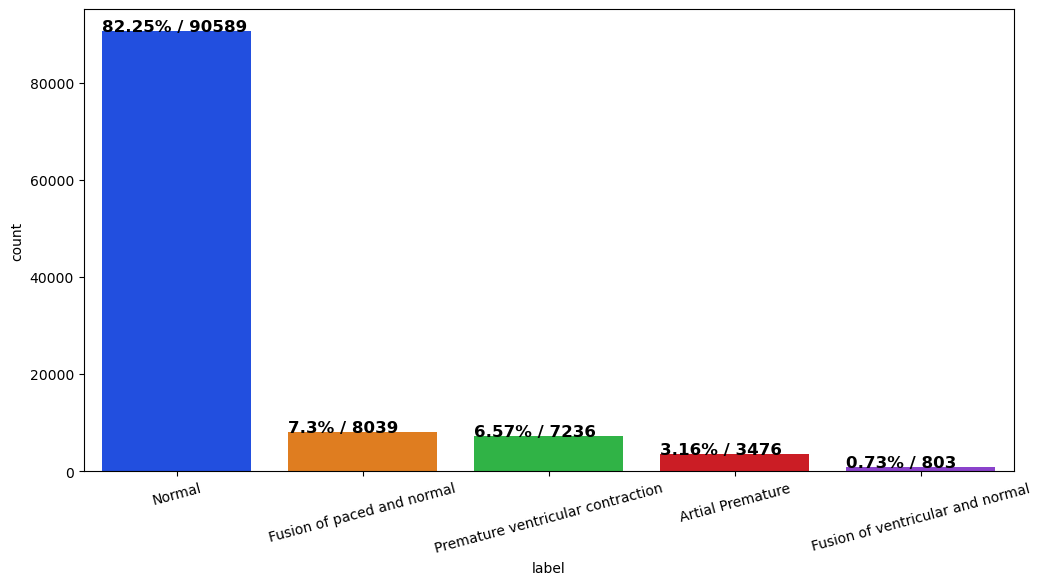

In [61]:
percentages = [count / df_mitbih.shape[0] * 100 for count in df_mitbih['label'].value_counts()]

fig, ax = plt.subplots(figsize=(12, 6))
sns.countplot(
    x=df_mitbih['label'],
    ax=ax,
    palette="bright",
    order=df_mitbih['label'].value_counts().index
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=15);

for percentage, count, p in zip(
    percentages,
    df_mitbih['label'].value_counts(sort=True).values,
    ax.patches):
    
    percentage = f'{np.round(percentage, 2)}%'
    x = p.get_x() + p.get_width() / 2 - 0.4
    y = p.get_y() + p.get_height()
    ax.annotate(str(percentage)+" / "+str(count), (x, y), fontsize=12, fontweight='bold')
    
plt.savefig('data_dist.png', facecolor='w', edgecolor='w', format='png',
        transparent=False, bbox_inches='tight', pad_inches=0.1)
plt.savefig('data_dist.svg', facecolor='w', edgecolor='w', format='svg',
        transparent=False, bbox_inches='tight', pad_inches=0.1)

# Dataset

In [62]:
class ECGDataset(Dataset):

    def __init__(self, df):
        self.df = df
        self.data_columns = self.df.columns[:-2].tolist()

    def __getitem__(self, idx):
        signal = self.df.loc[idx, self.data_columns].astype('float32')
        signal = torch.FloatTensor([signal.values])                 
        target = torch.LongTensor(np.array(self.df.loc[idx, 'class']))
        return signal, target

    def __len__(self):
        return len(self.df)

def get_dataloader(label_name, batch_size):
    df = pd.read_csv(config.csv_path)
    df = df.loc[df['label'] == label_name]
    df.reset_index(drop=True, inplace=True)
    dataset = ECGDataset(df)
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size, num_workers=0)
    return dataloader
    
    
dataloader = get_dataloader(label_name='Artial Premature', batch_size=96)

print(len(dataloader))
x,y = next(iter(dataloader))
x.shape, y.shape

37


(torch.Size([96, 1, 187]), torch.Size([96]))

# Models

In [63]:
import torch.nn as nn
import torch.nn.functional as F


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(256, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 187)
        self.rnn_layer = nn.LSTM(
                input_size=187,
                hidden_size=128,
                num_layers=1,
                bidirectional=True,
                batch_first=True,
            )
    def forward(self, x):
        x,_ = self.rnn_layer(x)
        x = x.view(-1,256)
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.dropout(x, p=0.2)
        x = self.fc3(x)
        return x.unsqueeze(1)


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.rnn_layer = nn.LSTM(
                input_size=187,
                hidden_size=256,
                num_layers=1,
                bidirectional=True,
                batch_first=True,
            )
        self.fc1 = nn.Linear(512, 512)
        self.fc2 = nn.Linear(512, 256) 
        self.fc3 = nn.Linear(256, 1)

    def forward(self, x):
        x,_ = self.rnn_layer(x)
        x = x.view(-1, 512)
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.dropout(x, p=0.2)
        x = torch.sigmoid(self.fc3(x))
        return x

# Training stage

In [64]:
class Trainer:
    def __init__(
        self,
        generator,
        discriminator,
        batch_size,
        num_epochs,
        label
    ):
        self.device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
        self.netG = generator.to(self.device)
        self.netD = discriminator.to(self.device)
        
        self.optimizerD = Adam(self.netD.parameters(), lr=0.0002)
        self.optimizerG = Adam(self.netG.parameters(), lr=0.0002)
        self.criterion = nn.BCELoss()
        
        self.batch_size = batch_size
        self.signal_dim = [self.batch_size, 1, 187]
        self.num_epochs = num_epochs
        self.dataloader = get_dataloader(
            label_name=label, batch_size=self.batch_size
        )
        self.fixed_noise = torch.randn(self.batch_size, 1, 187,
                                       device=self.device)
        self.g_errors = []
        self.d_errors = []
        
    def _one_epoch(self):
        real_label = 1
        fake_label = 0
        
        for i, data in enumerate(self.dataloader, 0):
            ##### Update Discriminator: maximize log(D(x)) + log(1 - D(G(z))) #####
            ## train with real data
            self.netD.zero_grad()
            real_data = data[0].to(self.device)
            # dim for noise
            batch_size = real_data.size(0)
            self.signal_dim[0] = batch_size
            
            label = torch.full((batch_size,), real_label,
                           dtype=real_data.dtype, device=self.device)
            
            output = self.netD(real_data)
            output = output.view(-1)
       
            errD_real = self.criterion(output, label)
            errD_real.backward()
            D_x = output.mean().item()
            
            ## train with fake data
            noise = torch.randn(self.signal_dim, device=self.device)
            fake = self.netG(noise)
            label.fill_(fake_label)
            
            output = self.netD(fake.detach())
            output = output.view(-1)
            
            errD_fake = self.criterion(output, label)
            errD_fake.backward()
            D_G_z1 = output.mean().item()
            errD = errD_real + errD_fake 
            self.optimizerD.step()
            
            ##### Update Generator: maximaze log(D(G(z)))  
            self.netG.zero_grad()
            label.fill_(real_label) 
            output = self.netD(fake)
            output = output.view(-1)
            
            errG = self.criterion(output, label)
            errG.backward()
            D_G_z2 = output.mean().item()
            self.optimizerG.step()
            
        return errD.item(), errG.item()
        
    def run(self):
        for epoch in range(self.num_epochs):
            errD_, errG_ = self._one_epoch()
            self.d_errors.append(errD_)
            self.g_errors.append(errG_)
            if epoch % 300 == 0:
                print(f"Epoch: {epoch} | Loss_D: {errD_} | Loss_G: {errG_} | Time: {time.strftime('%H:%M:%S')}")
   
                fake = self.netG(self.fixed_noise)
                plt.plot(fake.detach().cpu().squeeze(1).numpy()[:].transpose())
                plt.show()
            
        torch.save(self.netG.state_dict(), f"generator.pth")
        torch.save(self.netG.state_dict(), f"discriminator.pth")

In [65]:
g = Generator()
d = Discriminator()

Epoch: 0 | Loss_D: 0.9627628326416016 | Loss_G: 0.6465590596199036 | Time: 15:05:02


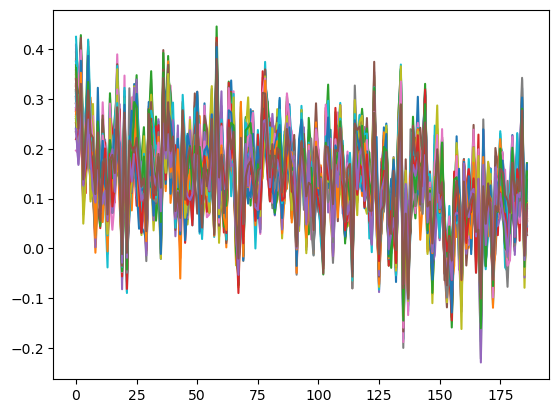

In [66]:
trainer = Trainer(
    generator=g,
    discriminator=d,
    batch_size=96,
    num_epochs=3000,
    label='Artial Premature'
)
trainer.run()

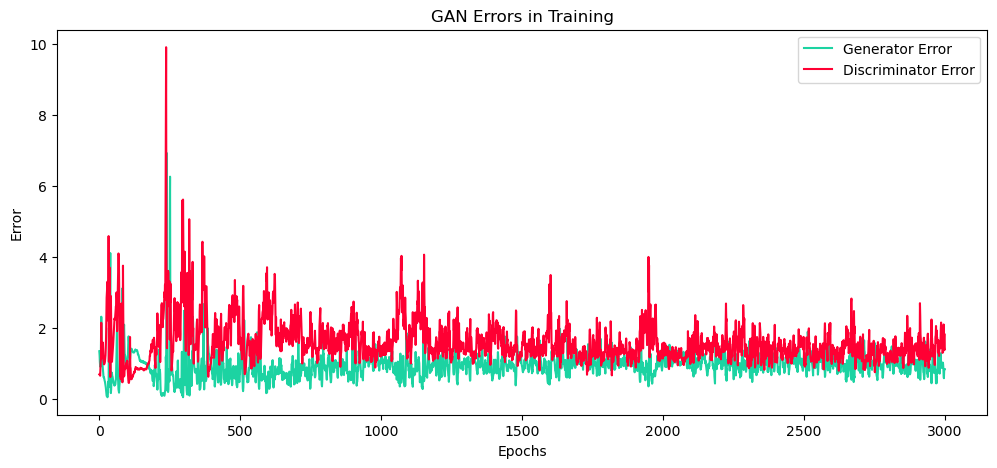

In [ ]:
plt.figure(figsize=(12, 5))
plt.title("GAN Errors in Training")
plt.plot(trainer.d_errors, label='Generator Error', c='#1CD3A2')
plt.plot(trainer.g_errors, label='Discriminator Error', c='#FF0033')
plt.xlabel("Epochs")
plt.ylabel('Error')
_ = plt.legend()
plt.savefig('Gan_Losses.png', facecolor='w', edgecolor='w', format='png',
        transparent=False, bbox_inches='tight', pad_inches=0.1)
plt.savefig('Gan_Losses.svg', facecolor='w', edgecolor='w', format='svg',
        transparent=False, bbox_inches='tight', pad_inches=0.1)

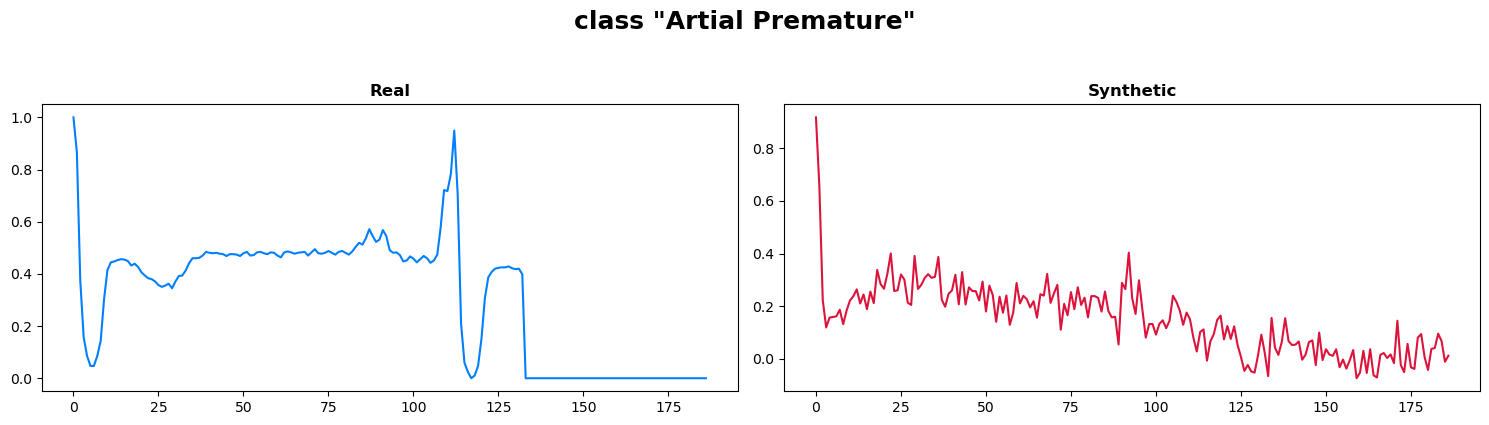

In [ ]:
df = pd.read_csv(config.csv_path)
df = df.loc[df['label'] == 'Artial Premature']

# real signal
N = 1
real_samples =  df.sample(N).values[:, :-2].transpose()

#synthetic signal
fake = trainer.netG(trainer.fixed_noise)
index = np.random.choice(fake.shape[0], N, replace=False) 
synthetic_samples = fake.detach().cpu().squeeze(1).numpy()[index].transpose()

fig, axs = plt.subplots(1, 2, figsize=(15, 4))


axs[0].plot(real_samples, c='#007FFF')
axs[0].set_title("Real", fontsize= 12, weight="bold")


axs[1].plot(synthetic_samples, c="crimson")
axs[1].set_title("Synthetic", fontsize= 12, weight="bold")

plt.suptitle('class "Artial Premature"', fontsize=18, y=1.05, weight="bold")
plt.tight_layout()
plt.savefig('Artial Premature.png', facecolor='w', edgecolor='w', format='png',
        transparent=False, bbox_inches='tight', pad_inches=0.1)
plt.savefig('Artial Premature.svg', facecolor='w', edgecolor='w', format='svg',
        transparent=False, bbox_inches='tight', pad_inches=0.1)

In [ ]:
# Save the GAN


In [ ]:
import pandas as pd
import numpy as np

# assume you have a trained generator function called "generate_sample"
# that takes a noise vector as input and returns a generated sample
# set the number of samples to generate
num_samples = 8000

# set the dimensionality of the noise vector to match the generator input
noise_dim = 100

# create an empty list to hold the generated samples
samples = []

# convert the list of samples to a pandas DataFrame
df = pd.DataFrame()

# generate X samples using the generator
for i in range(num_samples):
    # generate random noise vector
    noise = np.random.normal(0, 1, noise_dim)
    # generate a sample using the generator
    fake = trainer.netG(trainer.fixed_noise)
    index = np.random.choice(fake.shape[0], N, replace=False) 
    synthetic_samples = fake.detach().cpu().squeeze(1).numpy()[index].transpose()
    # Reshape the sample to be 1D
    synthetic_samples = synthetic_samples.reshape(1, -1)

    # add synthetic sample to the df as a row
    df = df.append(pd.DataFrame(synthetic_samples))


# save the DataFrame to a CSV file
df.to_csv('generated_samples.csv', index=False)

C:\Users\jespe\AppData\Local\Temp\ipykernel_34332\1958198357.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(synthetic_samples))
C:\Users\jespe\AppData\Local\Temp\ipykernel_34332\1958198357.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(synthetic_samples))
C:\Users\jespe\AppData\Local\Temp\ipykernel_34332\1958198357.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(synthetic_samples))
C:\Users\jespe\AppData\Local\Temp\ipykernel_34332\1958198357.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(synthetic_sample

In [ ]:
# # get the values in the range of 0 to 1
# df_norm = (df - df.min()) / (df.max() - df.min())

# # limit the range of the values between 0 and 1
# df_norm = df_norm * (1 - 0) + 0
# df_norm
# # save the DataFrame to a CSV file
# df_norm.to_csv('generated_samples1.csv', index=False)

In [ ]:
# def plot_ecg_examples(df, label, n_examples=5):    
#     filtered_df = df[df[187] == label]

#     # choose 5 random instances from the filtered DataFrame
#     random_instances = filtered_df.sample(n=n_examples, random_state=42)

#     return random_instances
# # Add column named 187 with only the value 1
# df_norm[187] = 1


# samples = list()
# samples.append(plot_ecg_examples(df_norm, 1, 5))

In [ ]:
# fig, axs = plt.subplots(3, 2, figsize=(10, 8))
# # titles = labels
# for i in range(1):
#     ax = axs.flat[i]
#     ax.plot(samples[i].values[:,:-2].transpose())
#     # ax.set_title(titles[i])

# fig.tight_layout()
# plt.show()

In [ ]:
# load the DataFrame from the CSV file
df_generated = pd.read_csv('generated_samples.csv')

In [ ]:
df_generated[187] = 1
df_generated

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.829417,0.865417,0.246766,0.026184,0.110988,0.132919,0.148502,0.230780,0.174749,0.253108,...,0.469758,0.411923,0.327298,0.315890,0.448882,0.353783,0.319052,0.284386,0.398847,1
1,0.832844,0.794524,0.212668,0.049002,0.101802,0.132425,0.140403,0.224098,0.177432,0.188067,...,0.307931,0.272423,0.221976,0.226143,0.324951,0.245557,0.242002,0.237125,0.254755,1
2,0.885048,0.996684,0.409808,0.067837,0.234303,0.170990,0.131038,0.217385,0.120870,0.258790,...,0.110292,-0.067671,-0.003064,0.055636,0.057147,0.125698,0.078258,-0.096725,-0.084631,1
3,0.884826,0.801331,0.162449,-0.026116,0.175539,0.112566,0.187048,0.235105,0.213557,0.157349,...,0.296004,0.283242,0.154524,0.214312,0.352534,0.216404,0.252863,0.153904,0.241210,1
4,0.904248,0.883592,0.226411,-0.008580,0.072804,0.089924,0.136394,0.200228,0.217257,0.249728,...,0.332592,0.292308,0.222727,0.219861,0.342125,0.261350,0.259559,0.231251,0.281933,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,0.765808,0.707401,0.162429,0.015627,0.127672,0.089708,0.135081,0.190243,0.153793,0.153118,...,0.322796,0.298418,0.194885,0.281220,0.381982,0.236576,0.265132,0.205998,0.275058,1
7996,0.718850,0.807129,0.351063,0.086729,0.119118,0.138238,0.108640,0.088686,0.042246,0.161915,...,0.058333,-0.056696,-0.065517,-0.002991,0.035513,0.099948,0.044346,-0.093025,-0.082431,1
7997,0.884976,0.783784,0.164770,-0.017159,0.155020,0.109381,0.138530,0.223676,0.160648,0.177725,...,0.320481,0.298387,0.174715,0.215159,0.359205,0.213953,0.287080,0.153502,0.234417,1
7998,0.895299,0.868513,0.178277,-0.047772,0.137488,0.121199,0.153224,0.266649,0.185064,0.179467,...,0.418212,0.387826,0.248659,0.289386,0.449146,0.316340,0.331930,0.225613,0.362108,1


In [ ]:
df_generated.to_csv('generated_samples.csv', index=False)

# Load in GAN

In [ ]:
generator_state_dict = torch.load('generator.pth')
generator1 = Generator()
generator1.load_state_dict(generator_state_dict)




<All keys matched successfully>

In [ ]:
# assume you have a trained generator function called "generate_sample"
# that takes a noise vector as input and returns a generated sample
# set the number of samples to generate
num_samples = 40

# set the dimensionality of the noise vector to match the generator input
noise_dim = 100

# create an empty list to hold the generated samples
samples = []

# convert the list of samples to a pandas DataFrame
df_asdf = pd.DataFrame()

for i in range(num_samples):
    # generate random noise vector
    noise = np.random.normal(0, 1, noise_dim)
    # generate a sample using the generator
    fake = generator1(trainer.fixed_noise)
    index = np.random.choice(fake.shape[0], N, replace=False) 
    synthetic_samples = fake.detach().cpu().squeeze(1).numpy()[index].transpose()
    # Reshape the sample to be 1D
    synthetic_samples = synthetic_samples.reshape(1, -1)

    # add synthetic sample to the df as a row
    df_asdf = df_asdf.append(pd.DataFrame(synthetic_samples))

# save the DataFrame to a CSV file
df_asdf.to_csv('generated_samples_test.csv', index=False)

C:\Users\jespe\AppData\Local\Temp\ipykernel_34332\2090726766.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_asdf = df_asdf.append(pd.DataFrame(synthetic_samples))
C:\Users\jespe\AppData\Local\Temp\ipykernel_34332\2090726766.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_asdf = df_asdf.append(pd.DataFrame(synthetic_samples))
C:\Users\jespe\AppData\Local\Temp\ipykernel_34332\2090726766.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_asdf = df_asdf.append(pd.DataFrame(synthetic_samples))
C:\Users\jespe\AppData\Local\Temp\ipykernel_34332\2090726766.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_asdf = df_a

# Conclusion
Since this is a standard process for training a GAN model, we can observe that the Generator produces predominantly dominant signal types.
More specifically, we have a total of 803 signals of the '"Fusion of ventricular and normal"' class, most of which are very similar, and that's what GAN model learned to generate.